In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#
%matplotlib inline

In [2]:
''' this cell is basically the python 3 version of the nrnvector file'''
import struct
import numpy as np
from tqdm import tqdm

type_length = {3: 4, # FLOAT
               4: 8, # #DOUBLE
               5: 4}  # INT

type_name = {3: 'float', # FLOAT
             4: 'double', # #DOUBLE
             5: 'int'}  # INT


def get_all_data_size(filename):
    n = 0
    ncell = 0
    ntype = None
    with open(filename, 'rb') as f:
        try:
            x = f.read(8) #read two integers
            on = True
        except:
            raise Exception('What!')

        while on:
            try:
                n1, ntype = struct.unpack('<ii', x) # read two integers
                n += n1 - 1 # subtract 1 from the cell index
                ncell += 1
                f.seek(n1*type_length[ntype], 1)
                x = f.read(8) # read two integers again
            except:
                f.close()
                on = False
        return (n, ncell, ntype)


def read_neuron_vectors(filename, data_size):
    ndata, ncell, ntype = data_size
    data = np.empty(ndata, dtype=type_name[ntype])
    cell = np.empty(ndata, dtype=int)

    count = 0
    mincell = ncell*100
    maxcell = 1
    with open(filename, 'rb') as f:
        for _ in tqdm(range(ncell)):
            x = f.read(8)
            n, ntype = struct.unpack('<ii', x)
            x = f.read(n*type_length[ntype])
            if n>1:
                st = np.fromstring(x, dtype=type_name[ntype])
                data[count:(count+n-1)] = st[1:]
                cell[count:(count+n-1)] = st[0]
                count = count + n-1
            else:
                st = np.fromstring(x, dtype=type_name[ntype])
            if mincell>st[0]:
                mincell = st[0]
            if maxcell<st[0]:
                maxcell = st[0]
        # print mincell, maxcell
    return (data, cell, int(mincell)-1)

def count_pre(post):
    "count_pre counts the number of presynaptic cells converging to each postsynaptic cell"
    cells = np.sort(np.unique(post))
    return cells, np.array([(post==c).sum() for c in cells])

In [3]:
filename = 'example_simulation/data/PFtoGoC.bin'
dsize = get_all_data_size(filename) # first we read the data size (number of cells, etc.)
pfs, gocs, _ = read_neuron_vectors(filename, dsize) # and read the data
pfs = pfs.astype(int)

100%|██████████| 1995/1995 [00:00<00:00, 2621.20it/s]


In [24]:
p1 = './example_simulation/coordinates_input/'

go_ori = p1+'GoCcoordinates.dat'
gr_ori = p1+'GCcoordinates.dat'

%run BREPpy.py
cp = Cell_pop('d')
cp.read_in_soma_file(go_ori)
go_s = cp.som
cp.read_in_soma_file(gr_ori)
gr_s = cp.som

print (len(go_s))

1995


In [83]:
cpop = gocs

def con_per_cell (ref, n_cells):
    cs, c_counts = np.unique(ref, return_counts = True)
    real_ccs = np.zeros(n_cells)
    print (max(cs))
    for i, c in enumerate( cs):
        real_ccs[int(c-1)] = c_counts[i]
    return real_ccs

c_gol = con_per_cell (gocs, len(go_s))
c_pf = con_per_cell (pfs, len(gr_s))


_ = plt.hist(c_gol,100)

plt.figure()
_ = plt.hist(c_pf, 100)

s_val = np.sort(real_ccs)

1995
799995


IndexError: index 798000 is out of bounds for axis 0 with size 798000

1995
1


In [47]:
import matplotlib as mpl
import matplotlib.cm as cm
norm = mpl.colors.Normalize(vmin=0, vmax=max(real_ccs))
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rgb = m.to_rgba(real_ccs)
print (rgb.shape)

(1995, 4)


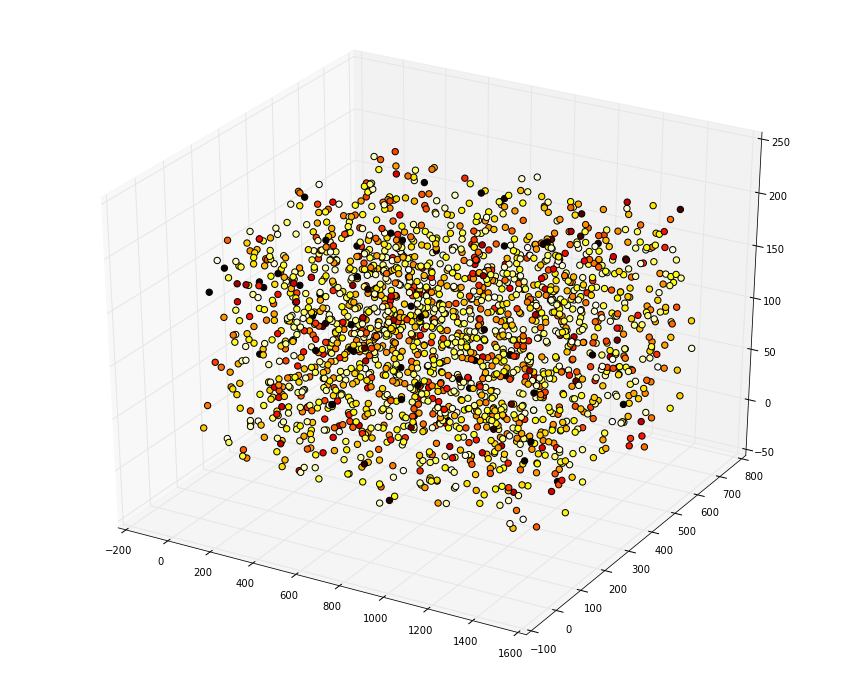

In [53]:
fig = plt.figure(figsize = (15,12))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(go_s[:,0], go_s[:,1], go_s[:,2], depthshade = False, facecolors = rgb, s  = 40)
plt.show()

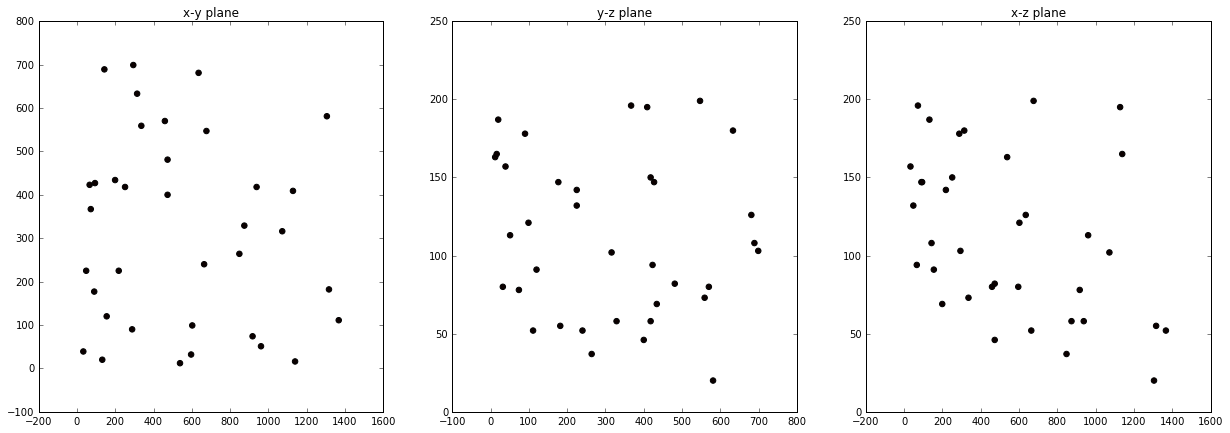

In [67]:
#2D projections
s_val = np.sort(real_ccs)
p10 = int(len(s_val)/10)
idx_top10 = real_ccs>s_val[9*p10]
idx_bot10 = real_ccs<s_val[p10]
idx_all = np.arange(len(s_val)-1)
idx_0  = real_ccs == 0


cur_idx = idx_0

plt.figure(figsize=(21,7))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    
    plt.subplot(1,3,i+1)
    
    plt.scatter(go_s[cur_idx,j], go_s[cur_idx,k], facecolors = rgb[cur_idx], s  = 30)
    #plt.axis('equal')
    
    if False:
        if i in [0,2]: plt.xlim([-100, 500])
    plt.title (tit)

In [75]:
def read_in_coordfile (fn, parse_ignore = True):
    '''
    reads in the file stored under fn (works for certain files that contain coordinates)
    Returns a np array with the data.
    If there is a problem parsing, this function will not break, however it will store it in a dict 
    If parse-ignore is set False, the number of unparsable signs as well as a set of them will be printed.
    '''
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    return np.asarray(res)

src_ori = read_in_coordfile('Output_default/output_16/AAtoGoCsources.dat')
src_fake = read_in_coordfile('testAAtoGoC_source.dat')
tar_ori =  read_in_coordfile('Output_default/output_16/AAtoGoCtargets.dat')
tar_fake = read_in_coordfile('testAAtoGoC_target.dat')

In [79]:
for f in [src_ori, src_fake, tar_ori, tar_fake]:
    print ('len', len(f))
    print ('min', min(f))
    print('max', max(f))
    


len 5952
min [ 112.]
max [ 49915.]
len 388354
min [ 0.]
max [ 13111.]
len 5952
min [ 0.]
max [ 124.]
len 388354
min [ 0.]
max [ 29.]


In [84]:
#so = con_per_cell (src_fake, max(tar_fake))
so = con_per_cell (src_ori, int(max(tar_ori)))
#c_pf = con_per_cell (pfs, len(gr_s))

plt.figure()
_ = plt.hist(so, 100)

49915.0


IndexError: index 141 is out of bounds for axis 0 with size 124

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = ax.hist(count_pf_to_goc, 100)
_ = ax.set(xlabel="PFs", ylabel="Count")